# Advanced Regression

## Predicting Property Value

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market.The company is looking at prospective properties to buy to enter the market.You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

### Objectives

Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

**Find out:**
1. Variables significant in predicting the price of a house
2. How well those variables describe the price of a house.
3. Determine the optimal value of lambda for ridge and lasso regression. 


## Step 1: Reading and Understanding the 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Step 2: Handling Missing Values

In [3]:
# Percentage of missing values in columns
(data.loc[:,data.isnull().sum() > 0].isnull().sum() / len(data) * 100).sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [4]:
# we will maintain a list of columns that we drop
cols_dropped = []

In [5]:
# handy function to drop columns inplace
def drop_columns_inplace(cols_to_drop, cols_dropped):
    cols_to_drop = list(set(cols_to_drop) - set(cols_dropped))
    data.drop(columns=cols_to_drop, inplace=True)
    cols_dropped += cols_to_drop

We will drop colums that have more than 15% of missing data.

These colums include:
<li> PoolQC, MiscFeature, Alley, Fence, FireplaceQu

In [6]:
drop_columns_inplace(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], cols_dropped)

<li>People generally spend money on outer aspects of the house and living rooms and dont really care of the basement quality and garage.

In [7]:
# removing colums regarding Garage and Basement as they don't matter that much
drop_columns_inplace(['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                      'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond',
                     'MasVnrArea', 'MasVnrType'], cols_dropped)

In [8]:
# Analyzing Electrical variable
data.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [9]:
# dropping electrical because 90% of values belong to one category and there is less information content
drop_columns_inplace(['Electrical'], cols_dropped)

## Step 2: Visualising the Data

<li>Lets check out the co-relation between the numeric variables to figure out if there are colums that are co-related with each other and we can drop some of them.
<li> We will drop colums that have strong co-relation (of more than 0.7) to each other

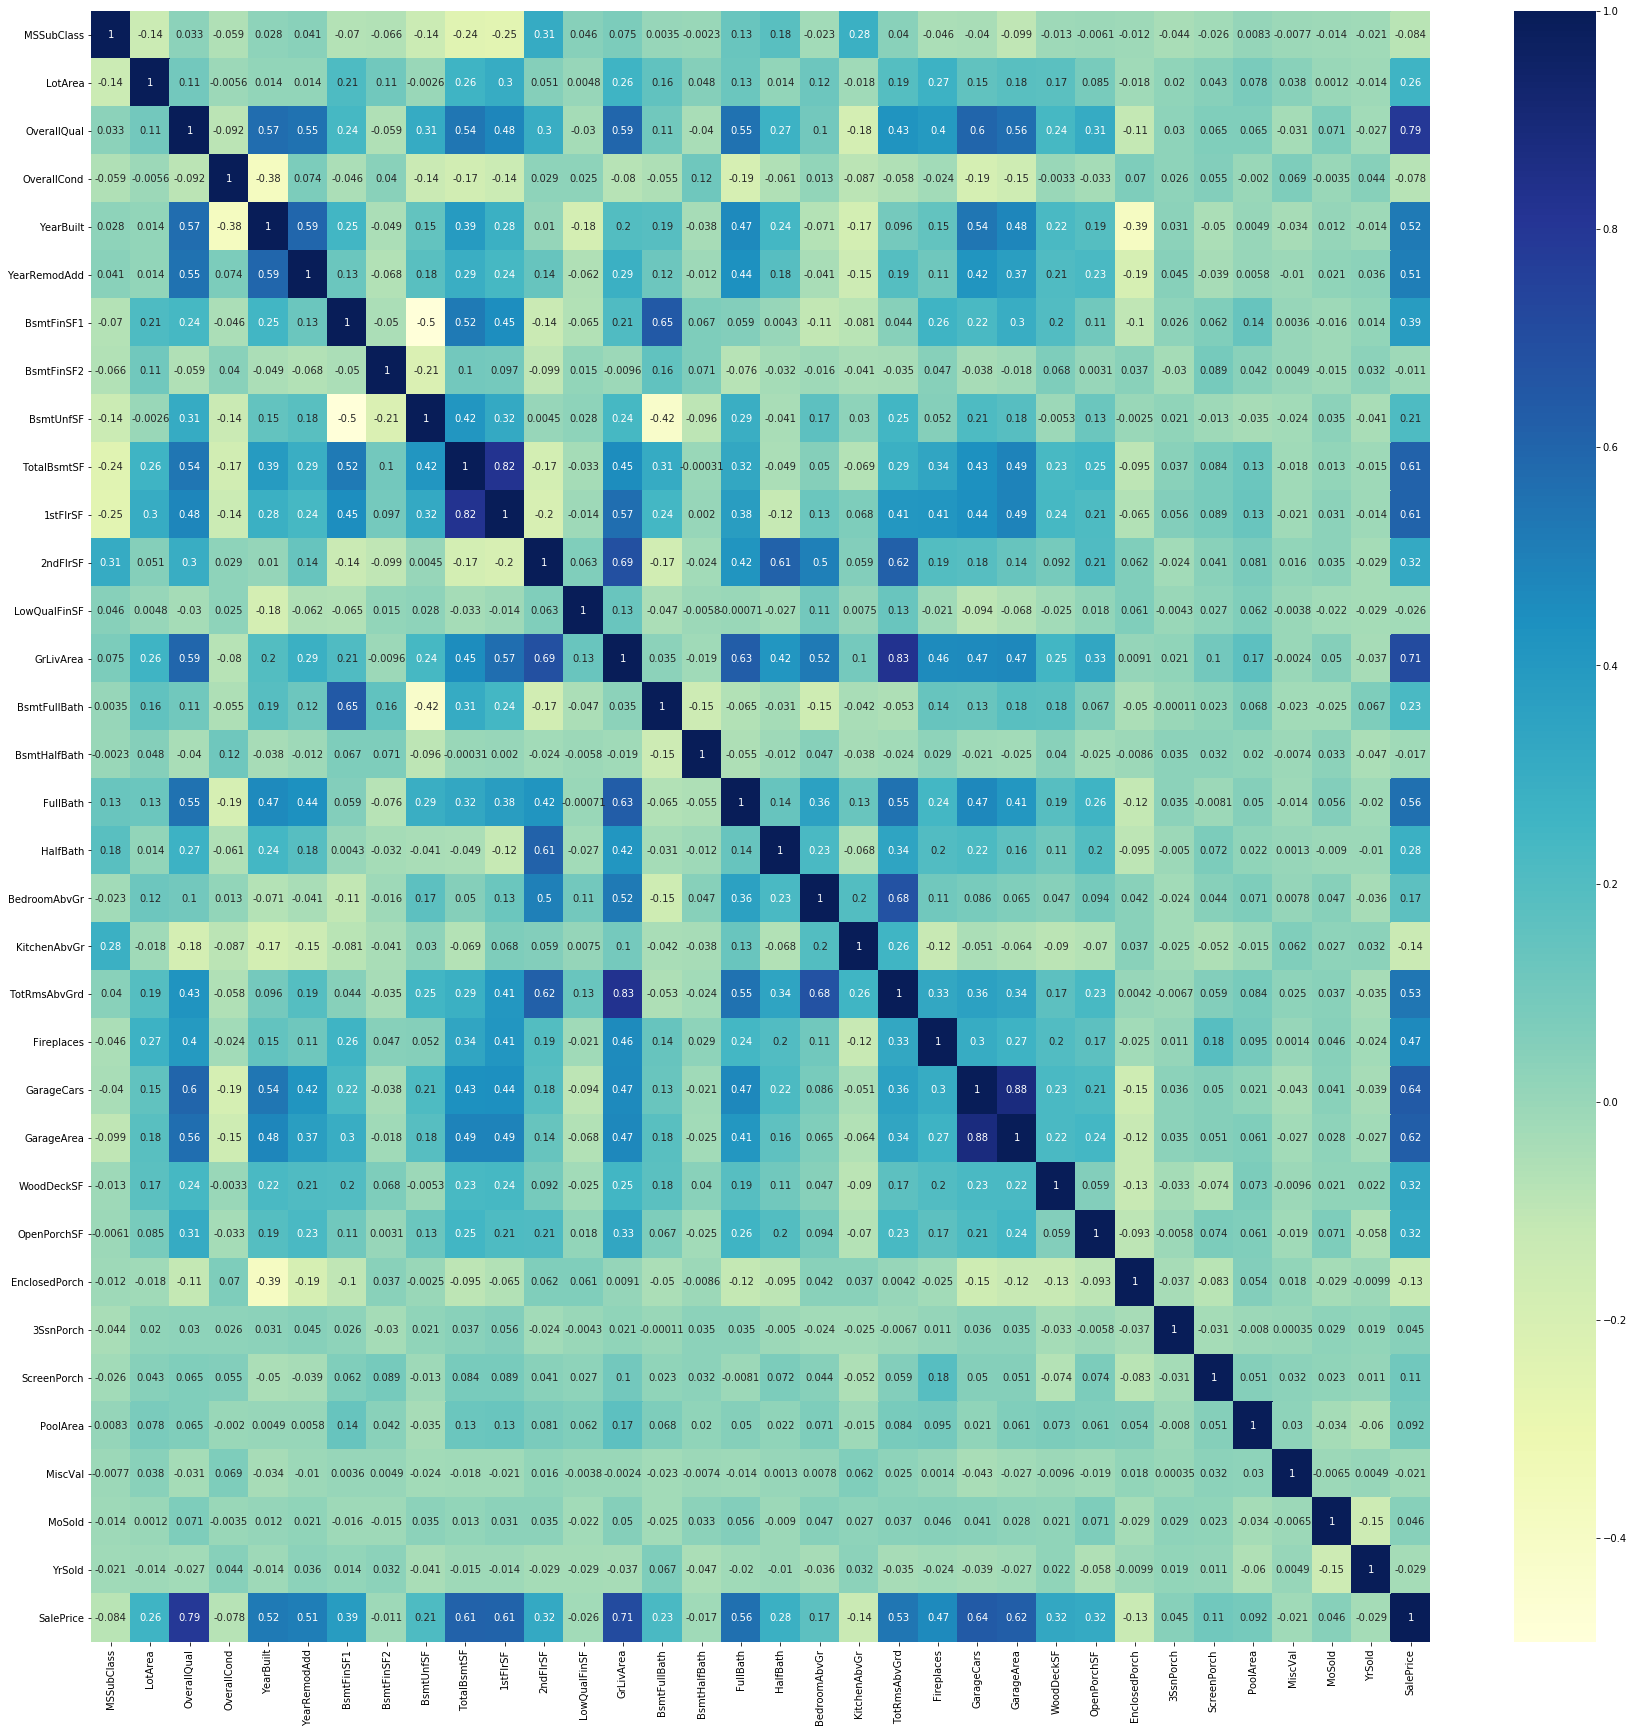

In [10]:
# correlation heatmap between
plt.figure(figsize=(30, 30))
sns.heatmap(data.corr(), cmap="YlGnBu", annot = True)
plt.savefig('heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
drop_columns_inplace(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd', 'BedroomAbvGr'], cols_dropped)

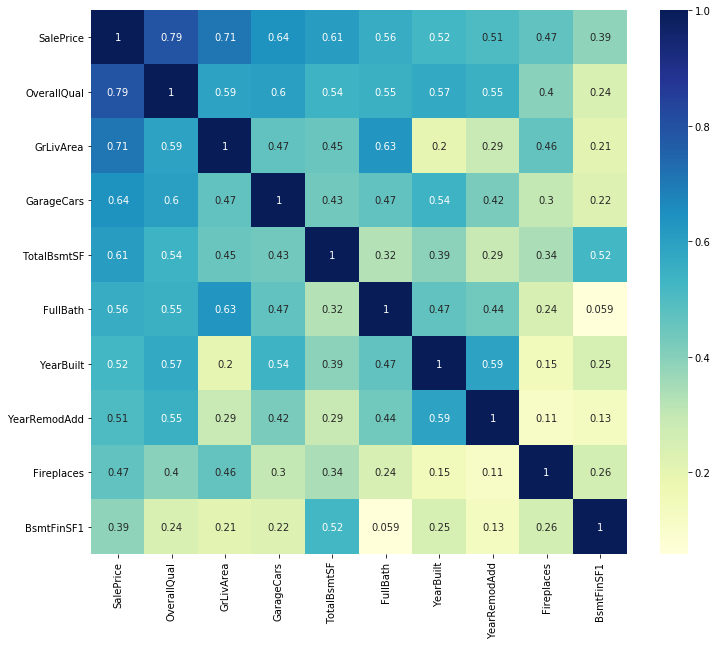

In [12]:
# finding the factors that correlate the most with SalesPrice
num_best_predictors = 10
cols = data.corr().nlargest(num_best_predictors, 'SalePrice')['SalePrice'].index
plt.figure(figsize=(12, 10))
sns.heatmap(data[cols].corr(), cmap="YlGnBu", annot = True)
plt.savefig('heatmaps2.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 576x576 with 0 Axes>

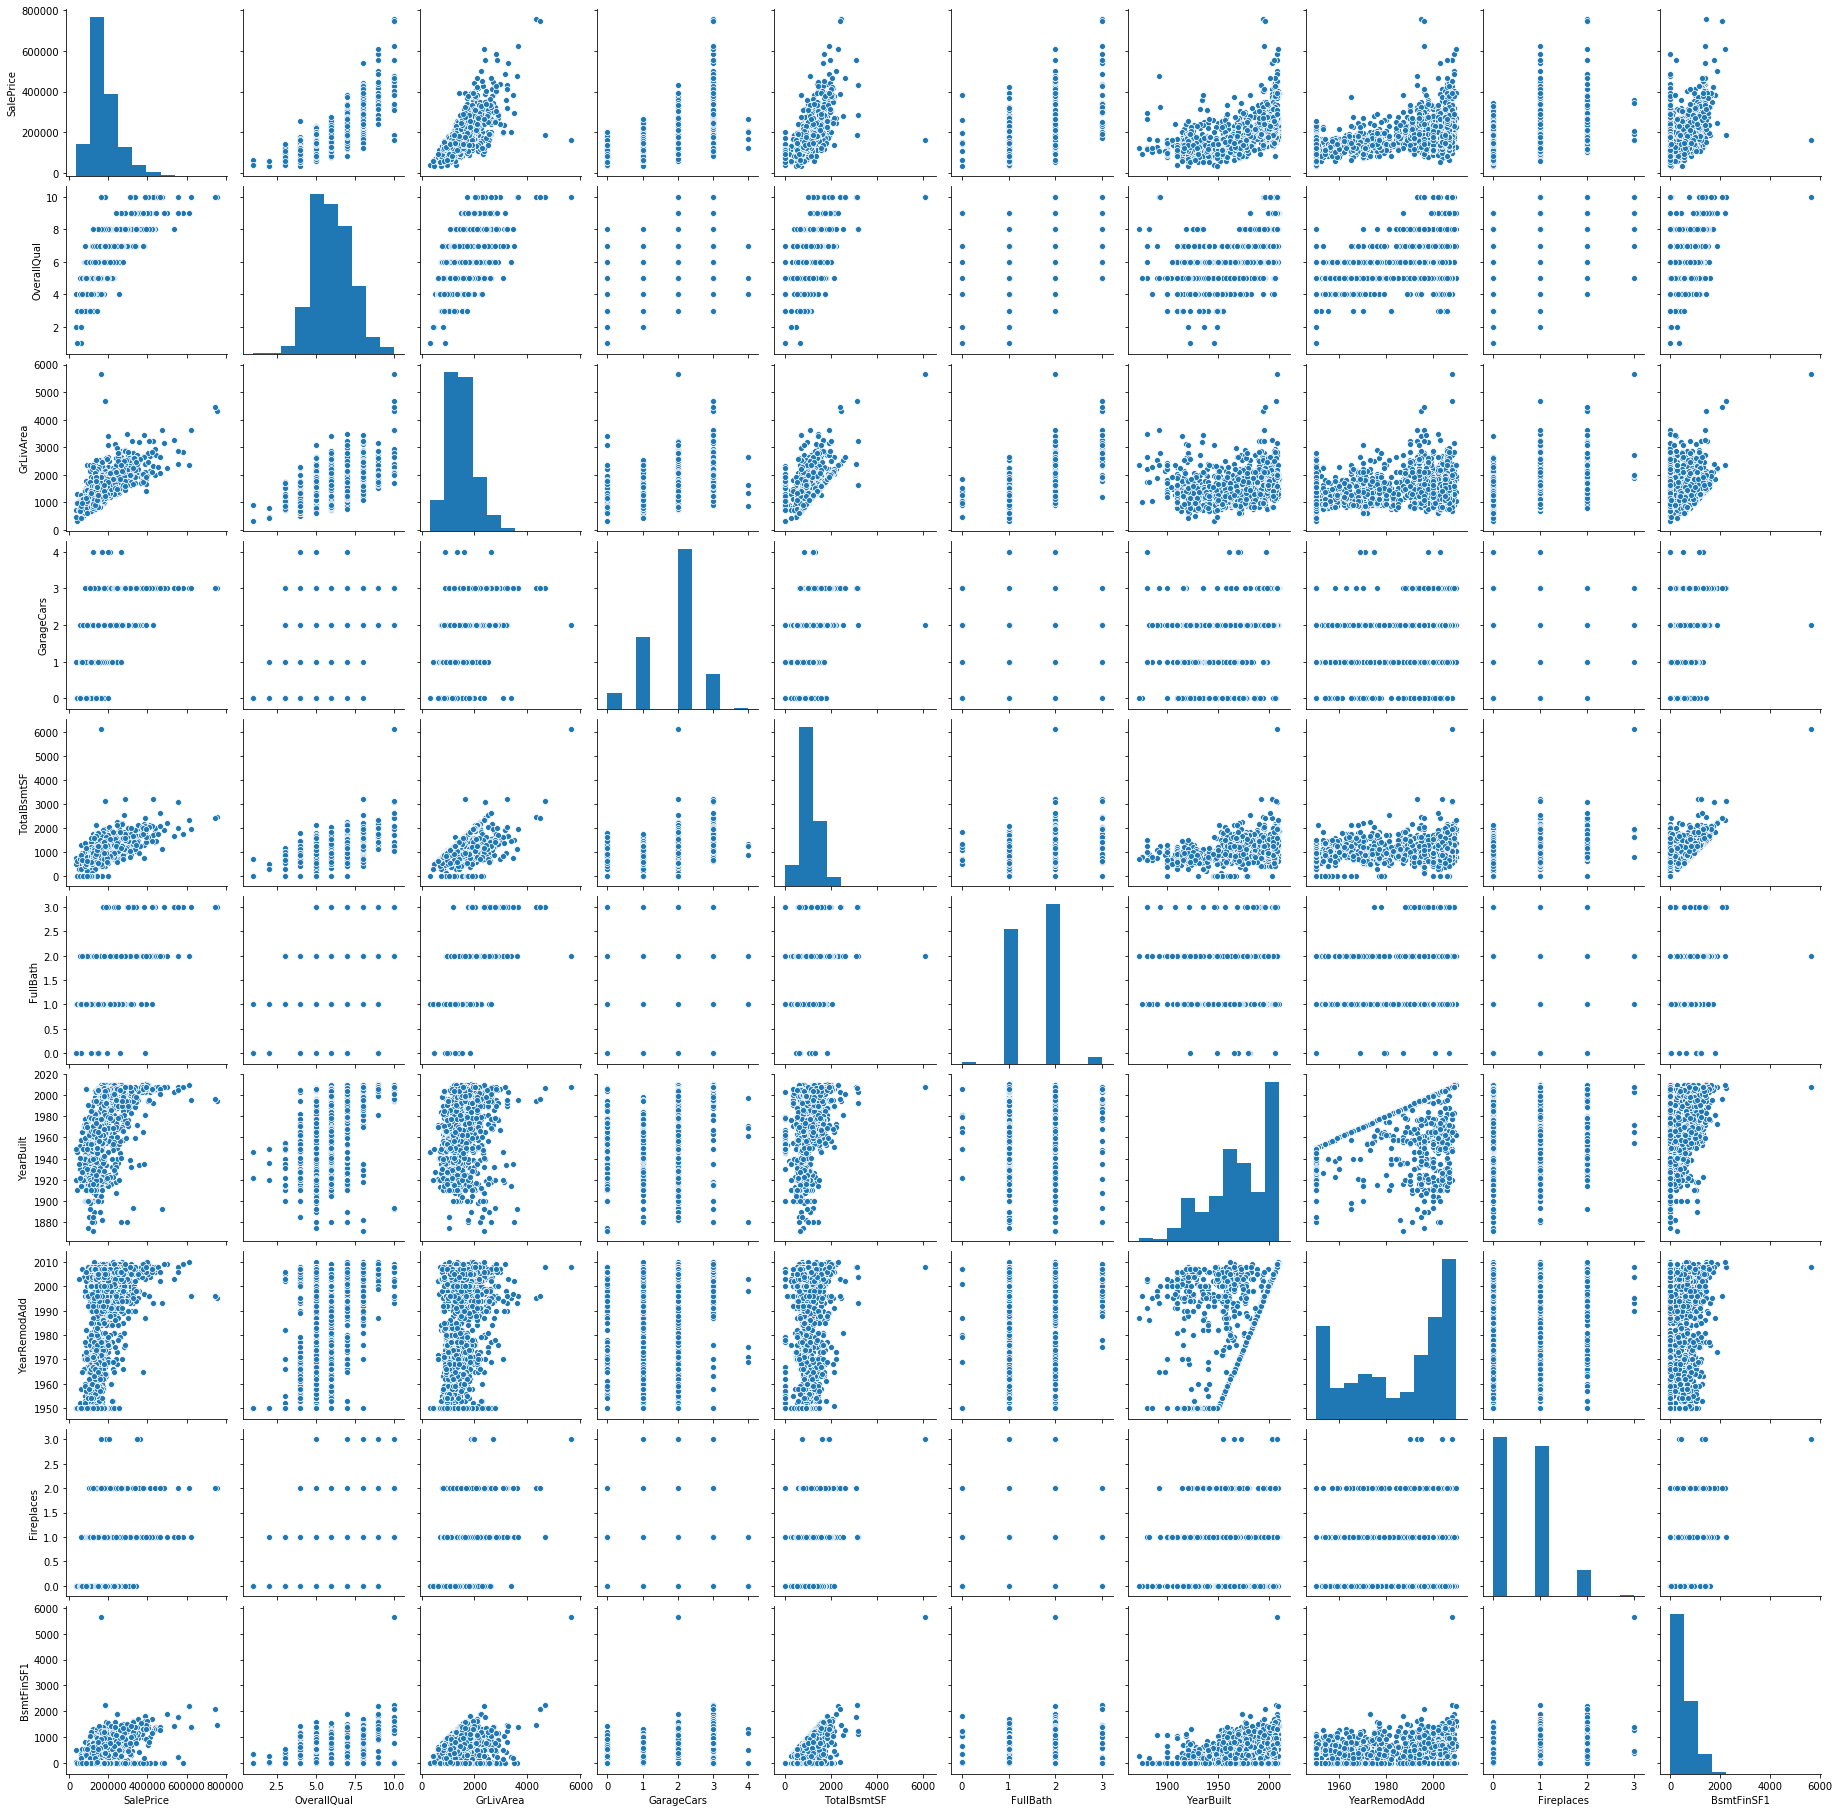

In [13]:
# the pairplot is saved as 'pairplots.png'... so no need to compute again
plt.figure(figsize=(8, 8))
sns.pairplot(data[cols])
plt.savefig('pairplots.png', dpi=300, bbox_inches='tight')
plt.show()

## Step 3: Data Preparation and Cleaning

<li> We will now look at various variables and transform them if need be
<li> categorical variables will be transformed to numerical if they represent an order
<li> numerical variables will be transformed if they are indeed categorical

In [14]:
# order for these numerical variables doesnt mean anything and it is more like a category
data.MSSubClass = data.MSSubClass.apply(str)

In [15]:
# segregate the cols into numerical and categorical
categorical_cols = data.dtypes[data.dtypes == 'object'].index
numerical_cols = data.dtypes[data.dtypes != 'object'].index

In [16]:
# label endcoding ordered categorical variables
ordered_categorical_cols = ['Street', 'LandSlope', 'ExterQual', 'ExterCond', 
                            'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive']

data = data.replace({
    "Street": {"Grvl": 1, "Pave": 2},
    "LandSlope": {"Gtl": 1, "Mod": 2, "Sev": 3},
    "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "CentralAir": {"N": 0, "Y": 1},
    "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2}
})

<li> We'll find skewness of numerical columns
<li> Highly skewed data is indicator of outliers
<li> We will scale/transform such variables to handle outliers

In [17]:
data[numerical_cols].skew().sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
OpenPorchSF       2.364342
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
YrSold            0.096269
FullBath          0.036562
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
dtype: float64

In [18]:
# dropping columns that are hightly skewed
drop_columns_inplace(['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 
                      'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 
                      'EnclosedPorch'], cols_dropped)

In [19]:
# log transform features with high skewness ( > 0.7)
cols_to_log_transform = ['LotArea', 'SalePrice', 'OpenPorchSF', 'BsmtFinSF1', 
                         'WoodDeckSF', 'GrLivArea', '2ndFlrSF']
data[cols_to_log_transform] = np.log1p(data[cols_to_log_transform])

In [21]:
# dummy encoding remaining categorical variables
data = pd.get_dummies(data)

In [22]:
data

,LotArea,Street,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,9.042040,2,1,7,5,2003,2003,4,3,6.561031,...,0,0,0,1,0,0,0,0,1,0
1,9.169623,2,1,6,8,1976,1976,3,3,6.886532,...,0,0,0,1,0,0,0,0,1,0
2,9.328212,2,1,7,5,2001,2002,4,3,6.188264,...,0,0,0,1,0,0,0,0,1,0
3,9.164401,2,1,7,5,1915,1970,3,3,5.379897,...,0,0,0,1,1,0,0,0,0,0
4,9.565284,2,1,8,5,2000,2000,4,3,6.486161,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,8.976894,2,1,6,5,1999,2000,3,3,0.000000,...,0,0,0,1,0,0,0,0,1,0
1456,9.486152,2,1,6,6,1978,1988,3,3,6.673298,...,0,0,0,1,0,0,0,0,1,0
1457,9.109746,2,1,7,9,1941,2006,5,4,5.620401,...,0,0,0,1,0,0,0,0,1,0
1458,9.181735,2,1,5,6,1950,1996,3,3,3.912023,...,0,0,0,1,0,0,0,0,1,0


In [460]:
data.to_csv('data_prepared.csv', index=False)

## Step 4: Splitting the Data into Training and Testing Sets

In [743]:
data = pd.read_csv('data_prepared.csv')

In [744]:
# segregate the cols into numerical and categorical
categorical_cols = data.dtypes[data.dtypes == 'object'].index
numerical_cols = data.dtypes[data.dtypes != 'object'].index

In [745]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
data_train, data_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

### Scaling the Features 

In [746]:
# scaling the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
data_train[numerical_cols] = scaler.fit_transform(data_train[numerical_cols])

In [747]:
y_train = data_train.pop('SalePrice')
X_train = data_train

In [748]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [749]:
def recursivelyEliminateFeatures(X_train, y_train, keep):
    # Running RFE with the output number of the variable equal to 10
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    rfe = RFE(lm, keep)
    rfe = rfe.fit(X_train, y_train)
    
    supported = list(X_train.columns[rfe.support_])
    
    unsupported = list(X_train.columns[~rfe.support_])
    
    return [rfe, supported, unsupported]

In [750]:
[rfe, supported, unsupported] = recursivelyEliminateFeatures(X_train, y_train, keep=100)

In [751]:
X_train = X_train[supported]

# Step 5: Model Building and Evaluation

In [752]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

## Ridge Regression

In [753]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [754]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002669,0.000613,0.000935,0.000144,0.0001,{'alpha': 0.0001},-0.062317,-0.055962,-0.054361,-0.061412,...,-0.059324,0.003458,23,-0.050474,-0.051950,-0.051715,-0.050635,-0.050098,-0.050974,0.000726
1,0.001920,0.000013,0.000728,0.000003,0.001,{'alpha': 0.001},-0.062313,-0.055961,-0.054360,-0.061406,...,-0.059321,0.003456,22,-0.050474,-0.051950,-0.051715,-0.050636,-0.050099,-0.050975,0.000726
2,0.002047,0.000213,0.000790,0.000037,0.01,{'alpha': 0.01},-0.062272,-0.055951,-0.054353,-0.061347,...,-0.059295,0.003443,21,-0.050480,-0.051949,-0.051718,-0.050641,-0.050107,-0.050979,0.000723
3,0.001991,0.000160,0.000842,0.000044,0.05,{'alpha': 0.05},-0.062092,-0.055912,-0.054326,-0.061097,...,-0.059182,0.003385,20,-0.050505,-0.051948,-0.051730,-0.050663,-0.050142,-0.050998,0.000711
4,0.001904,0.000165,0.000816,0.000035,0.1,{'alpha': 0.1},-0.061875,-0.055870,-0.054301,-0.060809,...,-0.059054,0.003318,19,-0.050534,-0.051947,-0.051745,-0.050689,-0.050181,-0.051019,0.000698
5,0.001856,0.000119,0.000800,0.000041,0.2,{'alpha': 0.2},-0.061467,-0.055790,-0.054267,-0.060301,...,-0.058830,0.003206,18,-0.050588,-0.051948,-0.051769,-0.050748,-0.050251,-0.051061,0.000673
6,0.001776,0.000008,0.000784,0.000010,0.3,{'alpha': 0.3},-0.061093,-0.055723,-0.054243,-0.059865,...,-0.058639,0.003116,16,-0.050641,-0.051955,-0.051793,-0.050827,-0.050319,-0.051107,0.000649
7,0.001770,0.000002,0.000780,0.000018,0.4,{'alpha': 0.4},-0.060752,-0.055664,-0.054227,-0.059485,...,-0.058472,0.003042,14,-0.050694,-0.051966,-0.051822,-0.050895,-0.050387,-0.051153,0.000628
8,0.001779,0.000020,0.000820,0.000071,0.5,{'alpha': 0.5},-0.060435,-0.055609,-0.054238,-0.059147,...,-0.058325,0.002973,13,-0.050754,-0.051979,-0.051854,-0.050958,-0.050450,-0.051199,0.000609
9,0.001852,0.000012,0.000805,0.000017,0.6,{'alpha': 0.6},-0.060142,-0.055560,-0.054269,-0.058844,...,-0.058197,0.002910,11,-0.050812,-0.051993,-0.051888,-0.051021,-0.050507,-0.051244,0.000593


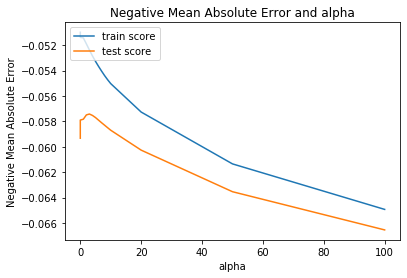

In [755]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [756]:
cv_results.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,0.001837,0.000033,0.000819,0.000028,3,{'alpha': 3.0},-0.057867,-0.055564,-0.055307,-0.055918,...,-0.057419,0.002667,1,-0.052200,-0.052736,-0.052800,-0.052417,-0.051730,-0.052377,0.000390
14,0.002131,0.000253,0.000877,0.000113,2,{'alpha': 2.0},-0.058297,-0.055459,-0.054884,-0.056612,...,-0.057489,0.002624,2,-0.051608,-0.052369,-0.052394,-0.051812,-0.051271,-0.051891,0.000436
16,0.001800,0.000008,0.000828,0.000028,4,{'alpha': 4.0},-0.057614,-0.055857,-0.055661,-0.055797,...,-0.057530,0.002693,3,-0.052743,-0.053115,-0.053222,-0.053008,-0.052122,-0.052842,0.000394
17,0.001788,0.000008,0.000812,0.000008,5,{'alpha': 5.0},-0.057497,-0.056229,-0.056000,-0.055797,...,-0.057698,0.002700,4,-0.053223,-0.053485,-0.053625,-0.053539,-0.052476,-0.053269,0.000419
13,0.002015,0.000080,0.000868,0.000070,1,{'alpha': 1.0},-0.059251,-0.055434,-0.054418,-0.057905,...,-0.057826,0.002751,5,-0.051018,-0.052062,-0.052019,-0.051257,-0.050740,-0.051419,0.000533
12,0.002022,0.000207,0.000856,0.000089,0,{'alpha': 0.9},-0.059437,-0.055439,-0.054378,-0.058099,...,-0.057896,0.002783,6,-0.050971,-0.052041,-0.051985,-0.051201,-0.050682,-0.051376,0.000546
18,0.001787,0.000010,0.000807,0.000010,6,{'alpha': 6.0},-0.057617,-0.056600,-0.056283,-0.055836,...,-0.057903,0.002702,7,-0.053652,-0.053815,-0.054009,-0.054020,-0.052829,-0.053665,0.000440
11,0.001936,0.000141,0.000791,0.000018,0,{'alpha': 0.8},-0.059648,-0.055468,-0.054336,-0.058323,...,-0.057982,0.002820,8,-0.050921,-0.052023,-0.051951,-0.051142,-0.050621,-0.051332,0.000560
10,0.001962,0.000240,0.000812,0.000038,0,{'alpha': 0.7},-0.059879,-0.055512,-0.054296,-0.058572,...,-0.058081,0.002861,9,-0.050867,-0.052007,-0.051918,-0.051083,-0.050560,-0.051287,0.000577
19,0.001858,0.000048,0.000812,0.000015,7,{'alpha': 7.0},-0.057818,-0.056944,-0.056512,-0.055876,...,-0.058106,0.002711,10,-0.054052,-0.054139,-0.054388,-0.054453,-0.053164,-0.054039,0.000463


In [757]:
alpha = 3
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 9.98213300e-03, -9.73675815e-02,  9.91141227e-03,  1.22112517e-02,
        4.47968523e-02,  3.04480652e-02,  1.77025913e-03,  4.07081225e-03,
        8.54123142e-03, -1.43823028e-02, -2.41034590e-02,  8.04284487e-04,
        2.84723935e-02, -5.17321893e-03,  6.49680704e-03,  2.21665206e-02,
       -2.29739054e-02, -6.23770319e-03,  5.48280879e-04,  3.30992607e-02,
        2.01514446e-02, -5.69673663e-02, -7.02046045e-02,  3.26407681e-02,
       -7.87198061e-05,  5.80708049e-02, -8.62079510e-02, -3.08069949e-02,
       -1.17128717e-01, -1.17411886e-01, -3.17726239e-02, -2.72605753e-02,
        7.97505313e-03,  3.22420224e-02,  1.25067068e-01,  1.24569626e-01,
       -7.66041951e-02, -4.53507503e-02, -4.50684539e-02,  6.54922554e-03,
        6.32513845e-02,  8.33080724e-02,  4.87943992e-02,  6.91437086e-02,
       -1.07885410e-02, -2.34888510e-02, -1.20607246e-02,  7.20221110e-02,
       -1.69659346e-02,  9.87664310e-03, -2.25340807e-02,  3.93937779e-03,
        3.35882871e-02,  

In [758]:
ridge_insights = pd.DataFrame({"variable":supported, "coeff": ridge.coef_, "abscoeff": abs(ridge.coef_)})

In [760]:
ridge_insights.sort_values(by=['abscoeff'], ascending=False)

,variable,coeff,abscoeff
34,Neighborhood_NoRidge,0.125067,0.125067
35,Neighborhood_NridgHt,0.124570,0.124570
29,Neighborhood_MeadowV,-0.117412,0.117412
28,Neighborhood_IDOTRR,-0.117129,0.117129
1,MSZoning_C (all),-0.097368,0.097368
...,...,...,...
6,LotShape_IR1,0.001770,0.001770
87,Functional_Mod,-0.001615,0.001615
11,LandContour_HLS,0.000804,0.000804
18,LotConfig_Inside,0.000548,0.000548


In [761]:
# rescaling test data
data_test[numerical_cols] = scaler.transform(data_test[numerical_cols])

In [762]:
y_test = data_test.pop('SalePrice')
X_test = data_test

In [763]:
X_test = X_test[supported]

In [764]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("R2 score of train data:", r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print("R2 score of test data:", r2_score(np.expm1(y_test), np.expm1(y_pred)))
    
    print("RMSE for train data:", np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print("RMSE for test data:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

In [765]:
evaluate_model(ridge, X_train, y_train, X_test, y_test)

R2 score of train data: 0.7045497270098167
R2 score of test data: 0.6673732349192056
RMSE for train data: 0.11962651966932854
RMSE for test data: 0.12919645869364146


## Lasso

In [701]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [702]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007533,0.002026,0.000953,0.000221,0.0001,{'alpha': 0.0001},-0.058836,-0.055323,-0.054933,-0.058267,...,-0.057831,0.002514,1,-0.051264,-0.052282,-0.052187,-0.051600,-0.051127,-0.051692,0.000470
1,0.003450,0.000602,0.000924,0.000111,0.001,{'alpha': 0.001},-0.061738,-0.061327,-0.059438,-0.058514,...,-0.061576,0.002898,2,-0.059121,-0.058808,-0.059365,-0.059665,-0.057791,-0.058950,0.000644
2,0.002126,0.000198,0.000867,0.000138,0.01,{'alpha': 0.01},-0.082571,-0.079431,-0.077105,-0.076050,...,-0.079943,0.003215,3,-0.078677,-0.079660,-0.080277,-0.080097,-0.079420,-0.079626,0.000564
3,0.001909,0.000093,0.000871,0.000117,0.05,{'alpha': 0.05},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
4,0.001792,0.000070,0.000773,0.000008,0.1,{'alpha': 0.1},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625


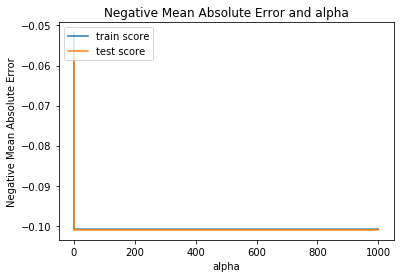

In [703]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [704]:
cv_results.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007533,0.002026,0.000953,0.000221,0.0001,{'alpha': 0.0001},-0.058836,-0.055323,-0.054933,-0.058267,...,-0.057831,0.002514,1,-0.051264,-0.052282,-0.052187,-0.051600,-0.051127,-0.051692,0.000470
1,0.003450,0.000602,0.000924,0.000111,0.0010,{'alpha': 0.001},-0.061738,-0.061327,-0.059438,-0.058514,...,-0.061576,0.002898,2,-0.059121,-0.058808,-0.059365,-0.059665,-0.057791,-0.058950,0.000644
2,0.002126,0.000198,0.000867,0.000138,0.0100,{'alpha': 0.01},-0.082571,-0.079431,-0.077105,-0.076050,...,-0.079943,0.003215,3,-0.078677,-0.079660,-0.080277,-0.080097,-0.079420,-0.079626,0.000564
15,0.001825,0.000073,0.000755,0.000004,3.0000,{'alpha': 3.0},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
26,0.001726,0.000014,0.000749,0.000009,500.0000,{'alpha': 500},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
25,0.001746,0.000017,0.000748,0.000008,100.0000,{'alpha': 100},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
24,0.001805,0.000046,0.000756,0.000009,50.0000,{'alpha': 50},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
23,0.001773,0.000024,0.000756,0.000009,20.0000,{'alpha': 20},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
22,0.001854,0.000136,0.000782,0.000063,10.0000,{'alpha': 10.0},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
21,0.001756,0.000014,0.000764,0.000008,9.0000,{'alpha': 9.0},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,4,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625


In [780]:
alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)
lasso.coef_

array([ 0.        , -0.12521756, -0.        , -0.        ,  0.02830861,
        0.02930819, -0.        ,  0.        ,  0.        , -0.01392819,
       -0.01560232,  0.00166551,  0.03108216, -0.00074454,  0.00572529,
        0.02020717, -0.02577207, -0.        , -0.        ,  0.03621882,
        0.        , -0.08690514, -0.09043897,  0.02712165, -0.        ,
        0.05377333, -0.09597912, -0.02657449, -0.14458224, -0.18017286,
       -0.0362459 , -0.03486267,  0.        ,  0.02631191,  0.1355207 ,
        0.13142504, -0.09954869, -0.05662019, -0.05223909,  0.00336402,
        0.06137021,  0.09686231,  0.05225091,  0.07903139, -0.        ,
       -0.        ,  0.        ,  0.20664463, -0.        ,  0.        ,
       -0.        ,  0.        ,  0.01494371,  0.        ,  0.        ,
       -0.06728492, -0.0317515 ,  0.00568783, -0.04164361, -0.0288089 ,
        0.05506805,  0.03650553,  0.01269208, -0.01470696, -0.00841001,
       -0.00865473, -0.02248277, -0.0445211 ,  0.0118211 ,  0.  

In [781]:
lasso_insights = pd.DataFrame({"variable":supported, "coeff": lasso.coef_, "abscoeff": abs(lasso.coef_)})

In [785]:
lasso_insights.sort_values(by=['abscoeff'], ascending=False).head(10)

,variable,coeff,abscoeff
47,Condition2_PosA,0.206645,0.206645
29,Neighborhood_MeadowV,-0.180173,0.180173
28,Neighborhood_IDOTRR,-0.144582,0.144582
34,Neighborhood_NoRidge,0.135521,0.135521
35,Neighborhood_NridgHt,0.131425,0.131425
1,MSZoning_C (all),-0.125218,0.125218
36,Neighborhood_OldTown,-0.099549,0.099549
41,Neighborhood_StoneBr,0.096862,0.096862
26,Neighborhood_Edwards,-0.095979,0.095979
22,Neighborhood_BrkSide,-0.090439,0.090439


In [783]:
evaluate_model(lasso, X_train, y_train, X_test, y_test)

R2 score of train data: 0.7104811733221279
R2 score of test data: 0.674508229262575
RMSE for train data: 0.11841962326075836
RMSE for test data: 0.12780328595205798
